In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import daft
import seaborn 
import matplotlib.pyplot as plt



C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


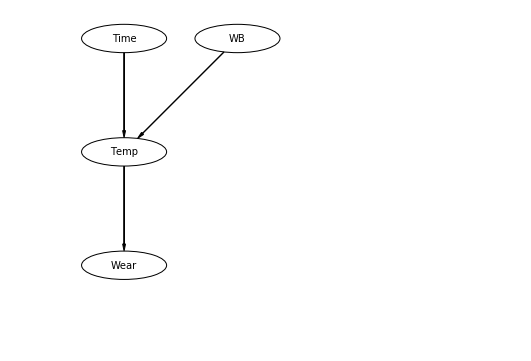

In [2]:
pgm = daft.PGM([9,6],origin=[1, 0.5])
pgm.add_node(daft.Node('Tme','Time',3,6,aspect=3))
pgm.add_node(daft.Node('WB','WB',5,6,aspect=3))
pgm.add_node(daft.Node('Temp','Temp',3,4,aspect=3))
pgm.add_node(daft.Node('Wear','Wear',3,2,aspect=3))
pgm.add_edge('Tme','Temp')
pgm.add_edge('WB','Temp')
pgm.add_edge('Temp','Wear')
pgm.render();


In [3]:
df = pd.read_csv('C:/Users/DESUSAI/Desktop/New folder/Temp.csv',sep=';')
Maxlife = 10000
intialTime=20
df

,Time,Temp,RunningTemp,Wear,Slot
0,1,200,200,16,1
1,1,100,166,13,2
2,1,100,166,12,3
3,1,200,166,20,4
4,1,100,166,15,5


In [4]:
df.describe()

,Time,Temp,RunningTemp,Wear,Slot
count,5.0,5.000000,5.000000,5.000000,5.000000
mean,1.0,140.000000,172.800000,15.200000,3.000000
std,0.0,54.772256,15.205262,3.114482,1.581139
min,1.0,100.000000,166.000000,12.000000,1.000000
25%,1.0,100.000000,166.000000,13.000000,2.000000
50%,1.0,100.000000,166.000000,15.000000,3.000000
75%,1.0,200.000000,166.000000,16.000000,4.000000
max,1.0,200.000000,200.000000,20.000000,5.000000


In [5]:
temp_mean= df.Temp.mean()
temp_mean

140.0

In [6]:
df.skew()

Time           0.000000
Temp           0.608581
RunningTemp    2.236068
Wear           0.933451
Slot           0.000000
dtype: float64

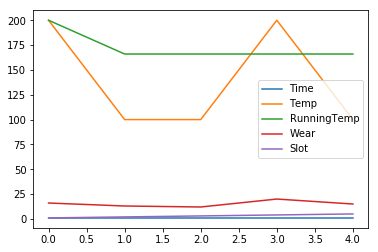

In [7]:
df.plot()
plt.show()

In [8]:
model = pm.Model();
with model:
    time = pm.Normal('time',intialTime)
    temp = pm.Normal('temp',mu=time)
    wear =pm.Normal('wear',mu=temp)
    trace = pm.sample(100000,tune=50000,progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|█████████████████████████████████| 150000/150000 [03:09<00:00, 789.54it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F1AE438>,
      dtype=object)

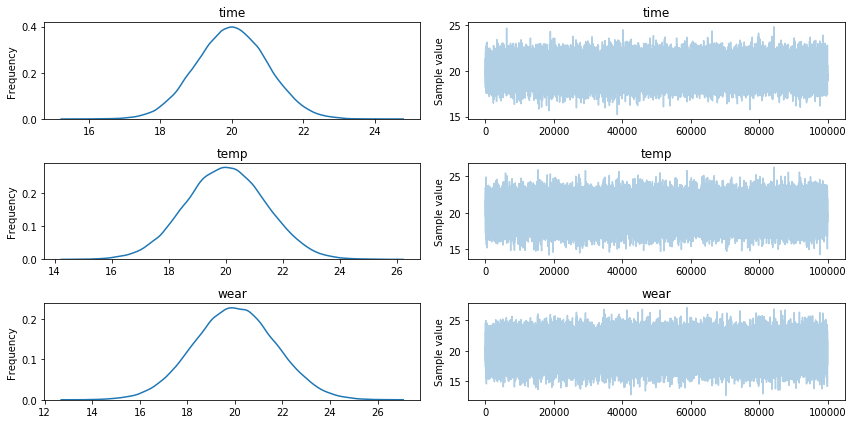

In [9]:
pm.traceplot(trace)

In [10]:
pm.summary(trace)


time:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  20.003           0.996            0.005            [18.047, 21.930]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  18.062         19.330         20.004         20.678         21.949


temp:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  20.005           1.405            0.008            [17.299, 22.778]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  17.266         19.056         20.002         20.955         22.749


wear:

  Mean             SD               MC Error         95% HPD interval
  ----------------------

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F43E908>,
      dtype=object)

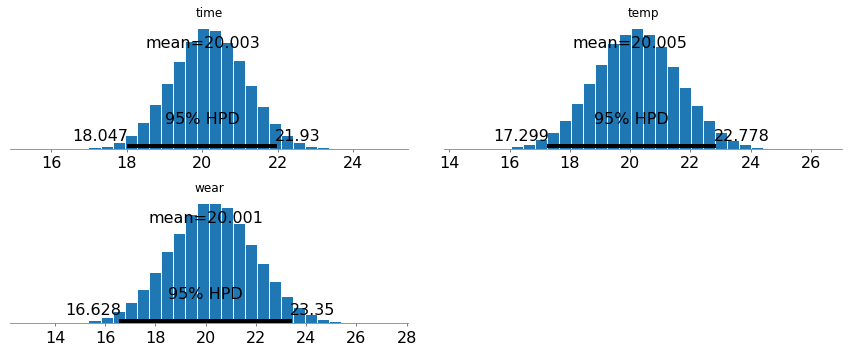

In [11]:
pm.plot_posterior(trace)

In [12]:
pred = pd.DataFrame({
    "Wear": trace["wear"][50000:],
    "Temp": trace["temp"][50000:],
    "Time": trace["time"][50000],
 
})


In [13]:
pred.Wear.mean()


20.00597120261414

In [14]:
pred.Temp.mean()
loopTime = pred.Time.mean()
loopWear = pred.Wear.mean()
loopTemp = pred.Temp.mean()

In [15]:
loopWear

20.00597120261414

In [16]:
loopTemp

20.013071189197284

In [17]:
loopTime

21.017528563848472

In [24]:
for i in range(0,len(df)-1):    
    model2 = pm.Model();    
    with model2:        
        Time2 = pm.Normal('Time2',df.Time[i])
        Temp2 = pm.Normal('Temp2',mu=Time2+loopWear)
        wear2 = pm.Normal('wear2',mu=Temp2+loopWear)
        changedWear= pm.Normal('changedWear',mu=wear2-loopWear)
        trace2 = pm.sample(10000,tune=5000,progressbar=True)    
        globals()["predStep" + str(i)]= pd.DataFrame({
                    "Wear": trace2["wear2"][5000:],
                    "temp": trace2["Temp2"][5000:],
                    "time": trace2["Time2"][5000:],
                    "WearChanged": trace2["changedWear"][5000:]            
        })        
        globals()["predStep" + str(i)].to_csv('C:/Users/DESUSAI/Desktop/New folder/predStep_' + str(i+1)+'.csv', sep=';')
               
        loopTime = globals()["predStep" + str(i)].time.mean()
        loopWear = globals()["predStep" + str(i)].Wear.mean()        
        print(df.Time[i],' sec',round(((Maxlife-loopWear)/Maxlife)*100),'% life is left')        
        
        
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|███████████████████████████████████| 15000/15000 [00:24<00:00, 606.46it/s]


1  sec 93 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████▉| 14962/15000 [00:23<00:00, 645.45it/s]C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.5862374997963571, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|███████████████████████████████████| 15000/15000 [00:23<00:00, 644.01it/s]


1  sec 87 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████| 15000/15000 [00:26<00:00, 573.87it/s]


1  sec 73 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████| 15000/15000 [00:25<00:00, 599.97it/s]


1  sec 46 % life is left


In [25]:
type(predStep0)

pandas.core.frame.DataFrame

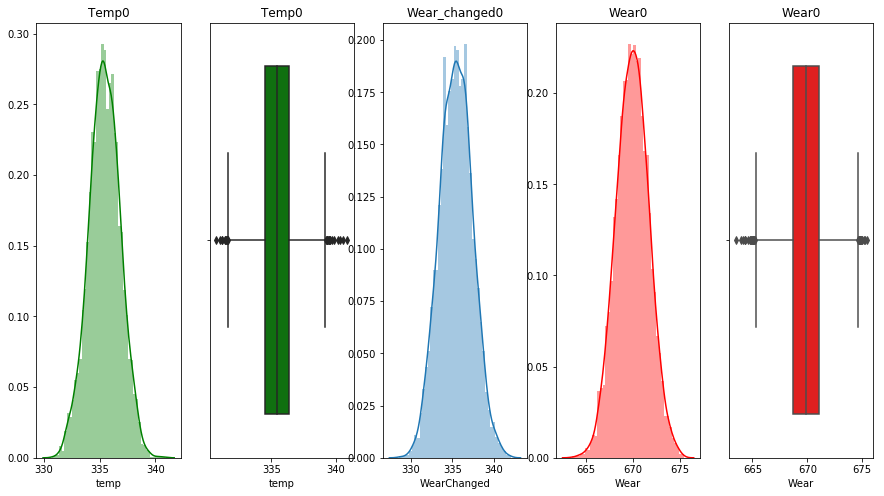

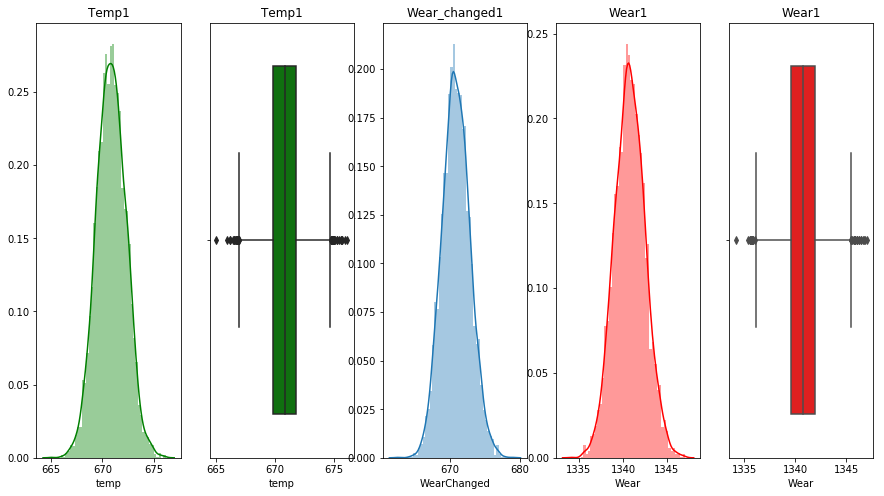

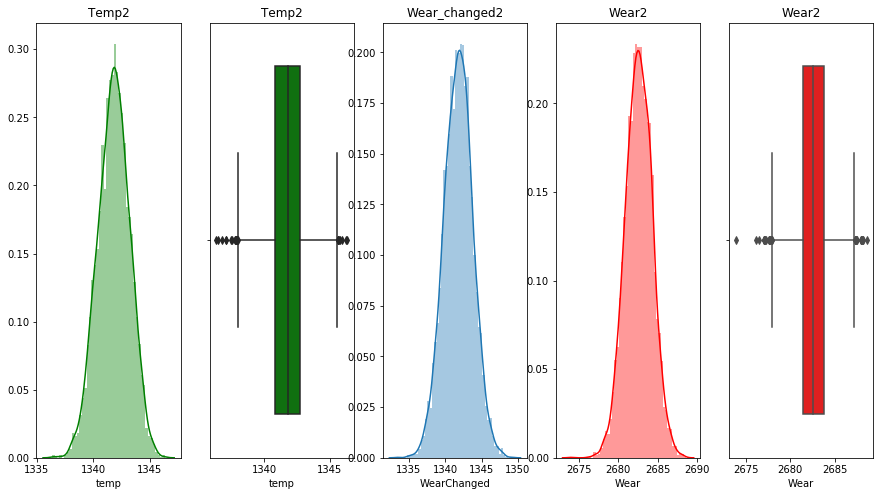

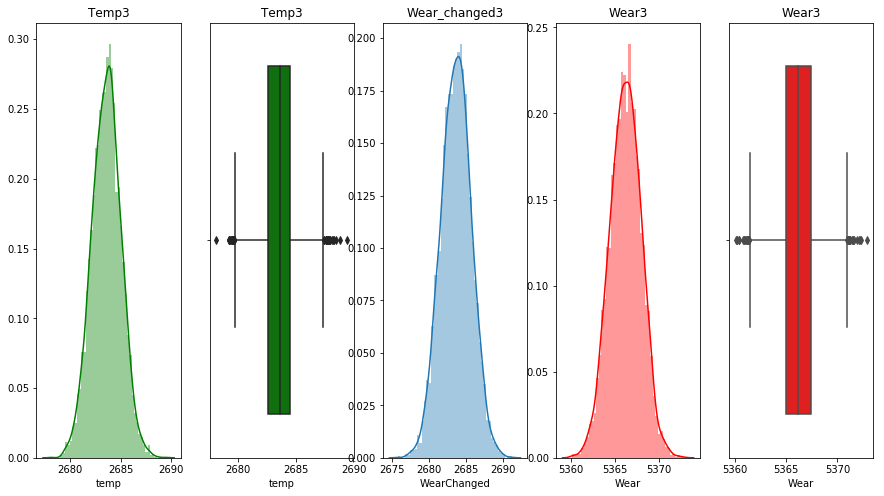

In [26]:
i=0
for i in range(0,len(df)-1):    
    fig, ax =plt.subplots(1,5)
    fig.set_figheight(8)
    fig.set_figwidth(15)    
    #plt.figure(i)
    #plt.grid(True)
    seaborn.distplot(globals()["predStep" + str(i)].temp,ax=ax[0],color='green').set_title("Temp"+str(i))
    seaborn.boxplot(globals()["predStep" + str(i)].temp,ax=ax[1],color='green').set_title("Temp"+str(i))
    seaborn.distplot(globals()["predStep" + str(i)].WearChanged,ax=ax[2]).set_title("Wear_changed"+str(i))
    seaborn.distplot(globals()["predStep" + str(i)].Wear,ax=ax[3],color='r').set_title("Wear"+str(i))
    seaborn.boxplot(globals()["predStep" + str(i)].Wear,ax=ax[4],color='r').set_title("Wear"+str(i))
    
    
    #seaborn.set_axis_labels("WearChanged","temp");
    #seaborn.distplot(globals()["predStep" + str(i)].Wear, ax=ax[1]).set_title("Wear"+str(i))    


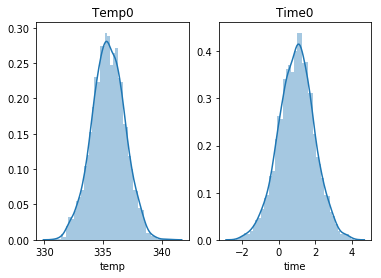

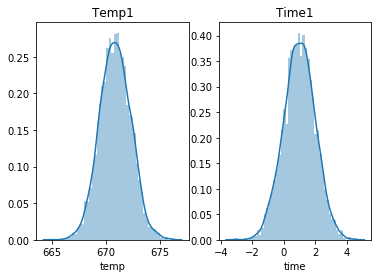

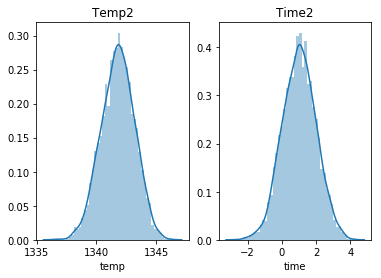

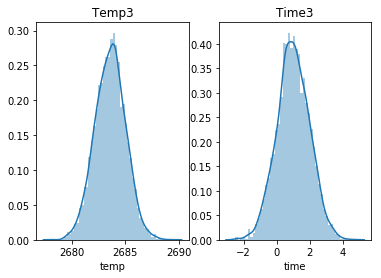

In [27]:
i=0
for i in range(0,len(df)-1):    
    fig, ax =plt.subplots(1,2)
    seaborn.distplot(globals()["predStep" + str(i)].temp,ax=ax[0]).set_title("Temp"+str(i))
    seaborn.distplot(globals()["predStep" + str(i)].time,ax=ax[1]).set_title("Time"+str(i))

    #seaborn.factorplot("Wear", data=globals()["predStep" + str(i)],ax=ax[1], kind="box")

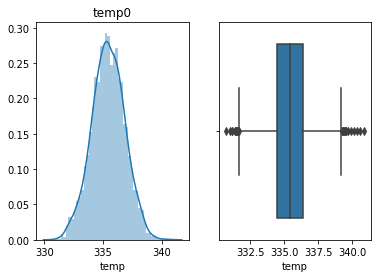

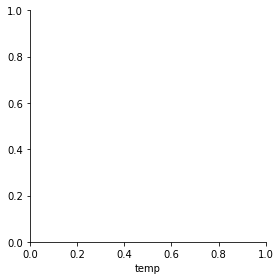

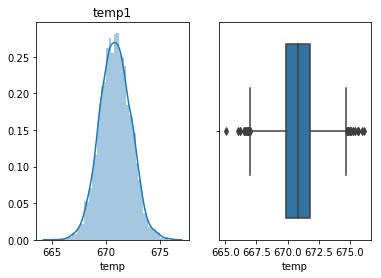

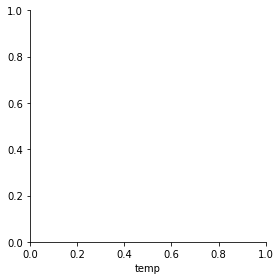

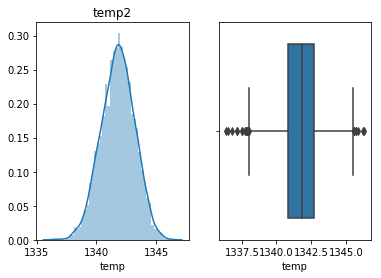

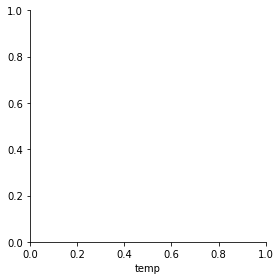

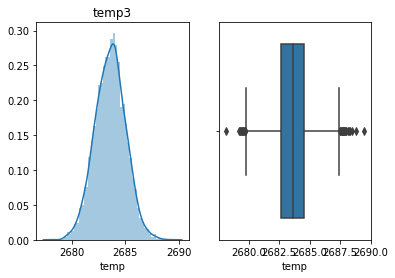

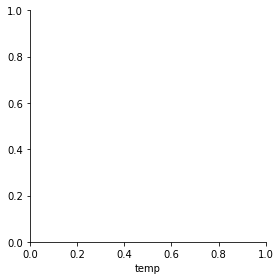

In [28]:
i=0
for i in range(0,len(df)-1):    
    fig, ax =plt.subplots(1,2)
    
    seaborn.distplot(globals()["predStep" + str(i)].temp,ax=ax[0]).set_title("temp"+str(i))    
    seaborn.factorplot("temp", data=globals()["predStep" + str(i)],ax=ax[1], kind="box") 
    

In [30]:
cdf = pd.read_csv("C:/Users/DESUSAI/Desktop/New folder/predStep_1.csv",sep=';')
cdf

,Unnamed: 0,Wear,WearChanged,temp,time
0,0,670.755542,335.189499,336.487728,1.334094
1,1,668.412303,334.556761,334.346954,0.769803
2,2,668.715681,333.134564,335.294052,0.615851
3,3,667.655086,332.872249,333.302246,1.093128
4,4,667.173777,332.616389,334.353991,0.757299
5,5,668.718104,334.630542,334.509552,-0.703452
6,6,667.335453,333.286951,333.804942,0.753760
7,7,667.206937,334.005817,334.976769,-0.116514
8,8,668.536879,332.078552,333.770741,-0.080900
9,9,669.180851,335.173106,337.317140,2.210304
